# Community Detection in Hypergraph Networks

## Workbench

In [1]:
import numpy as np
import pandas as pd
import random
from collections import Counter
import scipy.sparse as ssp
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
from multiprocessing import Pool, cpu_count
from functools import partial, reduce
from sklearn.manifold import TSNE
import sklearn.cluster as skcluster
from itertools import permutations, combinations, combinations_with_replacement 
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix
from scipy.special import comb
from itertools import groupby

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral
output_notebook()

Loading BokehJS ...

In [4]:
from numba import guvectorize
from numba import int64,float64
from numba import cuda

In [5]:
def get_nodes(x,G):
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: a edge-by-node incidence matrix
    with Pool(cpu_count()-1) as pool:
        E=Counter(pool.map(partial(get_nodes,G=G), (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    return E.keys()

def get_incidence(edges):
    indices=[]
    indptr=[0]
    for e in edges:
        indptr.append(indptr[-1]+len(e))
        indices+=list(e)
    return ssp.csr_matrix((np.ones(indptr[-1]), indices, indptr))

def load_edges(filename, sep='\t'):
    data=pd.read_csv(filename,sep)
    return ssp.csr_matrix((np.ones(len(data)),zip(*data.values)),shape=data.max().values+1)

In [6]:
# Given an edge-by-node incidence matrix, this function returns the submatrix corresponding to the largest connected component. 
# If the associated adjacency matrix is weighted, edges with weights less than the threshold will be removed before finding components.
def largest_component(G,threshold=None):
    P=G.T*G
    if threshold is None:
        weights=Counter(P.data)
        t=input("Tell me where to cut. Edges with weights >= will be kept. Here is the distribution of weights:\n{}".format(weights))
    else:
        t=threshold
    for i in range(1,t):
        P[P==i]=0
        P.eliminate_zeros()
    _,comp=ssp.csgraph.connected_components(P, directed=False)
    largest_comp=Counter(comp).most_common(1)[0]
    nodes=(comp==largest_comp[0]).nonzero()[0]
    G2=G[:,nodes]
    edges=G2.sum(axis=1).nonzero()[0]
    return G2[edges,:], nodes, edges

## Stochastic Block Model

* Given an order-$m$ hypergraph with $N$ nodes and $M$ hyperedges (edges for short). 
* Let $A$ be the order-$m$ adjacency tensor.  
* The stochastic block model for hypergraphs (SBMH) is defined as follows:
 * The nodes are divided into $K$ disjoint communities, $V=V_1\cap V_2 \cap \cdots \cap V_K$.
 * The probability that nodes $i_1,\cdots,i_m$ will form an edge is 
$$P(A[i_1,\cdots,i_m]=1) = C[g(i_1),\cdots,g(i_m)]\prod_{j\in\{i_1,\cdots,i_m\}}\theta_j,$$
where $g(i)$ is the community that node $i$ belongs to, and $\theta_i$ is a connectivity paramter for $i$.
 * $C$ is also an order-$m$ tensor and $C[g_1,\cdots,g_m]$ is the "density" of edges between communities $g_1,\cdots,g_m$. $C$ is much smaller than $A$.
* Let $Q$ be the tensor where $Q[i_1,\cdots,i_m]= P(A[i_1,\cdots,i_m]=1)$, $1\leq i_1,\cdots,i_m \leq N$, and $B$ be the matrix where $B[i,k]=1$ if node $i$ is in community $k$.
* Then SBMH can be written as
$$Q[i_1,\cdots,i_m] = \sum_{g_1,\cdots,g_m} C[g_1,\cdots,g_m] \theta_{i_1}B[i_1,g_1] \cdots \theta_{i_m} B[i_m,g_m].$$
* In tensor form, $Q = [C; \theta B, \cdots, \theta B]$.
* In other words, the SBMH assumes that the adjacency tensor can be approximated by a Tucker decomposition $[C; \theta B, \cdots, \theta B]$. 

In [7]:
# This function generate a hypergraph (actually, all hyperedges) from the SBM with the following C: the diagonal elements of C = pwithin and the off-diagonal elements of C = pbetween
def generate(N,m,comm,pwithin,pbetween):
    V=range(N)
    edges=set()
    typecount=[0,0]
    for e in combinations(V,m):
        if len(np.unique(comm[list(e)]))>1:
            p=pbetween
            t=1
        else:
            p=pwithin
            t=0
        if random.random()<=p:
            edges.add(e)
            typecount[t]+=1
    print("between: {}, within: {}".format(typecount[1],typecount[0]) )
    return list(edges)

## Hyper-SCORE

Given a hypergraph, hyper-SCORE fits the SBM to data and infers the community membership of nodes.
1. Perform a Tucker decomposition of the adjacency tensor $A$.
    1. Higher-order SVD (HOSVD) of $A$ as the initial decomposition. 
        1. Obtain the mode-1 matrix $A^{(1)}$ of $A$ by mapping indices as the following: $$A^{(1)}[i_1, \sum_{j=2}^m i_j N^{m-j}] = A[i_1,\cdots,i_m].$$
        2. Compute the $K$ left singular vectors $(u_1,\cdots,u_K)$ of $A^{(1)}$ corresponding to the $K$ largest singular values. 
            * If $A^{(1)}$ is too wide ($N$ by $N^{m-1}$) to do SVD, compute the eigen vectors of $A^{(1)}A^{(1)^T}$, since $A^{(1)}A^{(1)^T}$ can be much smaller than $A^{(1)}$ and can be calculated without constructing $A^{(1)}$ explicitely as follows.
            * Let $e_i$ ($e_j$) be an edge that contains $i$ ($j$), and $e_i - i$ be the set of nodes after removing $i$ from $e_i$. 
            * $[A^{(1)}A^{(1)^T}]_{ij}$ = number of pairs $(e_i, e_j)$ s.t. $e_i - i$ = $e_j - j$, for any $e_i, e_j$.
    2. Higher-order orthogonal iteration for improvements.
        1. Let $U=[u_1,\cdots,u_K]$. (Use the leading sigular vectors from HOSVD in the first iteration.)  
        2. Compute $$C[i_1, g_2, \cdots, g_m]=\sum_{i_2,\cdots,i_m} A[i_1,i_2,\cdots,i_m] U[i_2,g_2] \cdots U[i_m,g_m], 1\leq i_1,\cdots,i_m \leq N, 1\leq g_2, \cdots, g_m \leq K.$$
        3. Calculate the $K$ leading left singular vectors $(u_1,\cdots,u_K)$ of $C^{(1)}$, the mode-1 matrization of $C$. For even modest $m$ or $K$, $C^{(1)}$ will be very wide ($K^{m-1}$ columns), and computation needs to be arranged smartly to avoiding constructing the full $C^{(1)}$.
            1. Note that many columns of $C^{(1)}$ are repeated. The unique columns correpond to the outcomes of sampling $m-1$ elements from {1,2,...,K} with replacement. Each column $(g_2, \cdots, g_m)$ is repeated ($m-1$ choose $x_1$)*($m-1-x_1$ choose $x_2$)$\cdot\cdot\cdot$($m-1-x_1-...-x_{K-1}$ choose $x_K$), where $x_k$ is the number of elements equal to $k$.
            2. For each column $(g_2, \cdots, g_m)$, go over all the hyperedges. For each hyperedge $e$ and each node $v\in e$, this hyperedge contributes $\sum_{(i_2,\cdots,i_m)\in \pi(e/v)} U[i_2,g_2] \cdots U[i_m,g_m]$ to the $v$-th row of this column.
            3. Calculate the $K$ leading eigen-vectors of $C^{(1)}\cdot C^{(1)T}$. We can reorder the columns of $C^{(1)}$ and rewrite it as $[C_1,C_2,...,C_2,C_3,...,C_3...]$ where $C_i$ consists of a subset of the unique columns and it appears for as many times as its columns are repeated. Then $C^{(1)}\cdot C^{(1)T}=\sum_i r_iC_iC_i^T$ where $r_i$ is the number of times $C_i$ is repeated. 
        4. Repeat all steps above until convergence.
2. Compute $b_i=u_{i+1}/u_1$, $i=1,\cdots,K-1$.
3. Partition the rows of the matrix $[b_1,\cdots,b_{K-1}]$ with any clustering algorithm, e.g., k-means.

In [8]:
MAX_EDGE=10 #The biggest edge size that the algorithm will see. This is needed for pre-allocation.

### Higher-Order SVD

In [9]:
def count(x):
    return Counter([tuple(i) for i in x])

def preduce(A):
    chunks=cpu_count()-1
    with Pool(chunks) as pool:
        res=pool.map(count, np.array_split(A,chunks,axis=0))
    return reduce(lambda x,y:x+y, res)

@guvectorize([(int64[:],int64[:,:],int64[:])], '(N),(M,m)->(N)',target='cuda')
def hosvd_matrization_gpu(pair,T,res):
    i=pair[0]
    j=pair[1]
    for k in range(len(res)):
        res[k]=-1
    end=T.shape[1]
    indxi=0
    indxj=0
    ei=T[i,:]
    ej=T[j,:]
    overlap=cuda.local.array(MAX_EDGE,int64)
    v=0
    for k in range(end):
        overlap[k]=-1
        v+=k
    csame=0
    while indxi<end and indxj<end:
        if ei[indxi]==ej[indxj]:
            overlap[indxi]=indxj
            csame+=1
            indxi+=1
            indxj+=1
        elif ei[indxi]>ej[indxj]:
            indxj+=1
        else:
            indxi+=1
    if csame==(end-1):
        for k in range(len(overlap)):
            if overlap[k]==-1:
                u=ei[k]
            else:
                v-=overlap[k]
        v=ej[v]
        if u<v:
            res[0]=u
            res[1]=v
        else:
            res[0]=v
            res[1]=u

def hosvd_gpu(N,K,hyperedges,v0=None):
    M=len(hyperedges)
    m=len(hyperedges[0])
    T=cuda.to_device(np.array(hyperedges))
    indices=hosvd_matrization_gpu(list(combinations(range(M),2)),T)
    indices=indices.copy_to_host()
    indices=preduce(indices)
    del indices[(-1,-1)]
    
    H=ssp.coo_matrix((list(indices.values()),zip(*(indices.keys()))),shape=(N,N),dtype=float)
    H=H+H.T
    _,U=eigsh(H,K,v0=v0)

    return U

### Higher-Order Orthogonal Iteration

In [10]:
@guvectorize([(int64[:],int64[:,:],float64[:,:],int64[:,:],float64[:])], '(m1),(M,m),(N,K),(p,m1)->(N)',target='cuda')
def hooi_matrization_gpu(km, T, U, permute, res):
    m=T.shape[1]
    for i in range(len(res)):
        res[i]=0
    for i in range(T.shape[0]):
        for j in range(m):
            im=cuda.local.array(MAX_EDGE,int64)
            k=0
            for l in range(m):
                if l!=j:
                    im[k]=T[i,l]
                    k+=1
            for p in range(permute.shape[0]):
                prod=1.0
                for k in range(m-1):
                    prod*=U[im[permute[p,k]],km[k]]
                res[T[i,j]]+=prod

def comb2(e):
    c=Counter(e)
    res=1
    a=m-1
    for v in c.values():
        res*=comb(a,v)
        a=a-v
    return int(res)

def hooi_gpu(N, K, edges, U0, iterations=1, diagnose=True):
    m=len(edges[0])
    U_prev=U0
    U_new=U0
    permute=np.array(list(permutations(range(m-1))))
    permute=cuda.to_device(permute)
    T=cuda.to_device(np.array(edges))
    for iteration in range(iterations):
        cols=sorted(combinations_with_replacement(range(K), m-1), key=comb2)
        A=np.zeros([N,N])
        for k,sub_cols in groupby(cols,comb2):
            T2=hooi_matrization_gpu(list(sub_cols),T,U_prev,permute)
            T2=T2.copy_to_host()
            A+=k*T2.T.dot(T2)
#         U_new,_,_=ssp.linalg.svds(T2,k=K)
        _,U_new=eigh(A,eigvals=(N-K,N-1))
        if diagnose:
            print("Iteration: {}, Difference: {}".format(iteration, np.linalg.norm(abs(U_new)-abs(U_prev))), flush=True)
        U_prev=U_new
    return U_new

### SCORE

In [11]:
def score(G,K,eigs=False,project='binary'):
    if project not in ['binary', 'sum', 'normalized']:
        raise ValueError("Invalid projection type.")
    if project=='normalized':
        d=G.sum(axis=1).A.flatten()
        d=1/d
        D=ssp.diags(d)
        A=G.T*D*D*G
    else:
        A=G.T*G
    if project is 'binary':
        A.data=np.ones_like(A.data)
    _,U=eigsh(A,K)
    if eigs:
        return U
    B = U[:,:-1]/U[:,-1].reshape(len(U),1)
    return B

### Non-uniform Hypergraphs

If the hypergraph is not uniform (not all the hyperedges are of the same size), make all the hyperedges the same size by adding dummy nodes.

In [12]:
# Edges smaller than m will get dummy nodes, and edges larger than m will be projected to edges of size m.
# N: number of nodes.
# m: target uniform edge size.
# edges: input hyperedges.
# max_size: edges larger than max_size will be ignored. 
def homogenize(N,m,edges,max_size=None):
    if max_size is None:
        max_size=m
    min_size=m
    for e in edges:
        if (len(e)!=1 and len(e)<min_size):
            min_size=len(e)
    dummies=np.ones(m-min_size)*N + np.arange(m-min_size)
    dummies=tuple(dummies.astype(int))
    newedges=set()
    for e in edges:
        if len(e)<=1 or len(e)>max_size:
            continue
        if len(e)>m:
            for i in combinations(e,m):
                newedges.add(i)
        elif len(e)==m:
            newedges.add(e)
        else:
            newedges.add(e+dummies[len(e)-min_size:])
    return len(dummies), list(newedges)

##  Synthetic Data

Hypergraph generated from the SBM, with $N$ nodes, edges of size $m$, and $K$ communities. 

In [13]:
N=50
m=3
K=2
comm=np.zeros(N)
comm[25:]=1
pwithin=0.1
pbetween=0.01

In [14]:
edges = generate(N,m,comm,pwithin,pbetween)

between: 167, within: 487


#### HOSVD

In [15]:
U0 = hosvd_gpu(N,K,edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

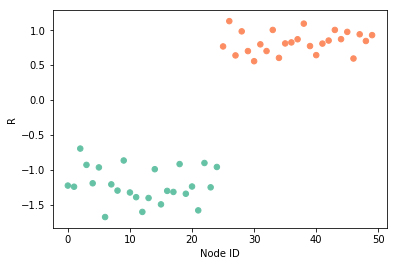

In [16]:
plt.scatter(range(len(B0)), B0, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));
plt.xlabel('Node ID');
plt.ylabel('R');

In [17]:
labels = skcluster.KMeans(n_clusters=K).fit(B0[:N,:])
Counter(labels.labels_)

Counter({0: 25, 1: 25})

In [18]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

1.0
1.0
1.0
1.0
1.0


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


#### HOOI

In [19]:
U=hooi_gpu(N, K, edges, U0, iterations=10, diagnose=True)
B = U[:,:-1]/U[:,-1].reshape(len(U),1)

Iteration: 0, Difference: 0.17876936834384866
Iteration: 1, Difference: 0.03805321874068803
Iteration: 2, Difference: 0.01316645309101559
Iteration: 3, Difference: 0.005368656541156046
Iteration: 4, Difference: 0.0023474280641055836
Iteration: 5, Difference: 0.001058677422633988
Iteration: 6, Difference: 0.00048513568123183904
Iteration: 7, Difference: 0.00022480098257433945
Iteration: 8, Difference: 0.00010488491504794689
Iteration: 9, Difference: 4.9239829307779384e-05


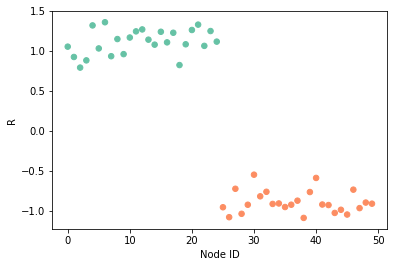

In [20]:
plt.scatter(range(len(B)), B, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));
plt.xlabel('Node ID');
plt.ylabel('R');

In [21]:
labels = skcluster.KMeans(n_clusters=K).fit(B)
Counter(labels.labels_)

Counter({0: 25, 1: 25})

In [22]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

1.0
1.0
1.0
1.0
1.0


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


#### SCORE

In [23]:
G=get_incidence(edges)

In [24]:
B2=score(G,K)

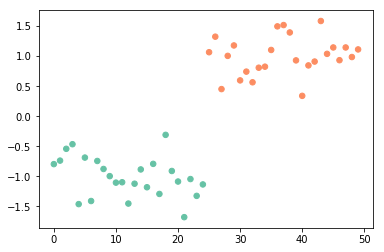

In [25]:
plt.scatter(range(len(B2)), B2, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));

In [26]:
labels = skcluster.KMeans(n_clusters=K).fit(B2)
Counter(labels.labels_)

Counter({1: 25, 0: 25})

In [27]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

1.0
1.0
1.0
1.0
1.0


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


## Real Data

### Dataset 1: Legislator Network

* Node: congressman of Peru.
* Edge: a bill proposed in the congress of Peru.

#### Data

In [89]:
G=load_edges('../Data/Legislator/legislator.csv')
N=G.shape[1]

In [90]:
df=pd.read_csv('../Data/Legislator/legislator_party.csv',sep='\t')
comm=np.zeros(N,dtype=int)
comm[df['node_id']]=df['party_id']

In [91]:
edges=get_hyperedges(G)

In [92]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 19), (3, 5), (4, 14), (5, 15), (6, 805), (7, 743), (8, 446), (9, 245), (10, 142), (11, 104), (12, 60), (13, 53), (14, 41), (15, 34), (16, 26), (17, 17), (18, 16), (19, 8), (20, 8), (21, 4), (22, 6), (23, 1), (24, 3), (25, 2), (26, 2), (27, 1), (28, 1), (29, 2), (31, 1), (33, 1), (34, 1), (40, 1), (49, 1), (60, 1), (65, 1)]


#### Homogenize

In [93]:
# Add dummy nodes to make all edges of size $m$
m=6
dummies,regular_edges=homogenize(N,m,edges,8)

#### HOSVD

In [95]:
K=7

In [96]:
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

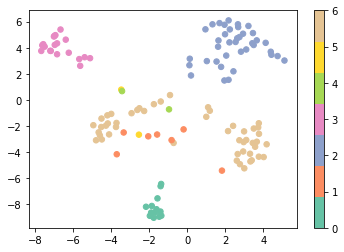

In [97]:
pos = TSNE(n_components=2).fit_transform(B0[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", K)));
plt.colorbar();

In [98]:
labels = skcluster.KMeans(n_clusters=K).fit(B0[:N,:])
Counter(labels.labels_)

Counter({2: 17, 5: 23, 0: 9, 3: 24, 1: 11, 6: 29, 4: 17})

In [101]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

0.5418694285608133
0.5856888300180197
0.6858466457903286
0.7614341853361974
0.6177626781153178


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [102]:
contingency_matrix(comm,labels.labels_)  

array([[ 2, 11,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  9,  0,  0,  0, 29],
       [ 1,  0,  1,  0, 17,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  6, 24,  0, 18,  0]])

#### HOOI

In [103]:
U=hooi_gpu(N+dummies, K, regular_edges, U0, iterations=5, diagnose=True)

Iteration: 0, Difference: 2.9522267844963395
Iteration: 1, Difference: 0.49442772726696704
Iteration: 2, Difference: 0.27346377704428987
Iteration: 3, Difference: 0.2514949332309892
Iteration: 4, Difference: 0.21824167603073086


In [127]:
# x=U[:N,-1]
# d=(x==0)
# x[d]=1
B = U[:N,:-1]/x.reshape(N,1)
# B[d,:]=B.max()
B[B>100]=100
B[B<-100]=-100

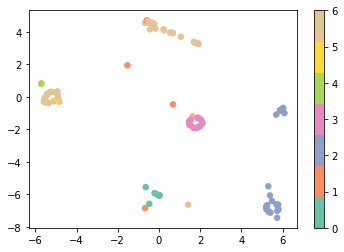

In [128]:
pos = TSNE(n_components=2).fit_transform(B)
plt.scatter(pos[:N,0],pos[:N,1],s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 7)));
plt.colorbar();

In [129]:
labels = skcluster.KMeans(n_clusters=K).fit(B)
Counter(labels.labels_)

Counter({0: 24, 1: 23, 6: 8, 2: 23, 4: 16, 5: 15, 3: 21})

In [130]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

0.49514759637656053
0.5815588231774814
0.6847784049971937
0.7640726524298505
0.6137131887383607


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [131]:
contingency_matrix(comm,labels.labels_)  

array([[ 0,  0,  0,  0, 13,  0,  0],
       [ 1,  0,  2,  3,  1,  0,  0],
       [ 0, 23,  0,  0,  0, 15,  0],
       [ 0,  0, 19,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0],
       [21,  0,  1, 18,  1,  0,  8]])

#### SCORE

In [132]:
B2=score(G,K)

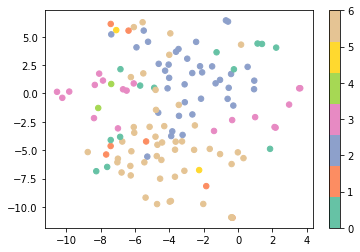

In [133]:
pos = TSNE(n_components=2).fit_transform(B2)
plt.scatter(pos[:,0],pos[:,1],s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 7)));
plt.colorbar();

In [135]:
labels = skcluster.KMeans(n_clusters=K).fit(B2)
Counter(labels.labels_)

Counter({2: 53, 0: 39, 4: 23, 5: 5, 3: 3, 6: 2, 1: 5})

In [136]:
print(metrics.adjusted_rand_score(comm,labels.labels_))
print(metrics.adjusted_mutual_info_score(comm,labels.labels_))
print(metrics.normalized_mutual_info_score(comm,labels.labels_))
print(metrics.homogeneity_score(comm,labels.labels_)  )
print(metrics.completeness_score(comm,labels.labels_)  )

0.31066922132328034
0.28634076962263005
0.3562642762069815
0.34569185652809226
0.3671600360391192


/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/bill10/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [137]:
contingency_matrix(comm,labels.labels_)  

array([[ 5,  0,  4,  0,  2,  2,  0],
       [ 0,  1,  4,  0,  2,  0,  0],
       [29,  0,  7,  0,  0,  0,  2],
       [ 0,  0,  3,  3, 10,  3,  0],
       [ 0,  0,  0,  0,  2,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  0],
       [ 4,  4, 35,  0,  6,  0,  0]])

### Dataset 2: Stats Paper citation

* Node: paper
* Edge: a set of papers cited by a paper

#### Data

In [62]:
G=load_edges('../Data/Stats_citation/citation.tsv',sep='\t')
N=G.shape[1]

In [63]:
G2, nodes, _=largest_component(G,2)
N=G2.shape[1]

In [65]:
node_df=pd.read_csv('../Data/Stats_citation/paperList.txt')
node_df['ID']=node_df.index
node_df=node_df.merge(pd.DataFrame({"ID":nodes}), on='ID')

In [66]:
edges=get_hyperedges(G2)
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 130), (3, 106), (4, 82), (5, 70), (6, 51), (7, 37), (8, 28), (9, 17), (10, 24), (11, 14), (12, 9), (13, 5), (14, 2), (15, 1), (18, 1), (19, 1), (21, 1)]


#### Homogenize

In [67]:
# Add dummy nodes to make all edges of size $m$
m=7
dummies,regular_edges=homogenize(N,m,edges,8)

#### HOSVD

In [68]:
K=5

In [69]:
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

In [74]:
labels = skcluster.KMeans(n_clusters=K).fit(B0[:N,:])
Counter(labels.labels_)

Counter({0: 376, 3: 20, 1: 3, 4: 1, 2: 1})

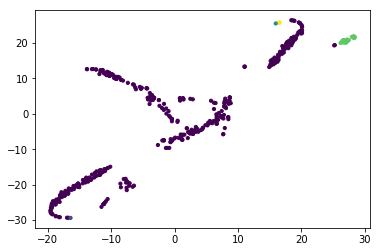

In [72]:
pos = TSNE(n_components=2).fit_transform(B0[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=10,c=labels.labels_);

In [73]:
cmap=factor_cmap(field_name='c', palette=Spectral[K], factors=[str(i) for i in range(K)])

source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_df['title'],
            s=node_df['citCounts']/2,
            c=[str(i) for i in labels.labels_]
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s',color=cmap,source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

#### HOOI

In [83]:
U=hooi_gpu(N+dummies, K, regular_edges, U0, iterations=5, diagnose=True)

Iteration: 0, Difference: 2.702570694663899
Iteration: 1, Difference: 2.170421834412296
Iteration: 2, Difference: 2.8286557060533615
Iteration: 3, Difference: 0.40660877311377075
Iteration: 4, Difference: 2.0190533127517036


In [85]:
x=U[:N,-1]
d=(x==0)
x[d]=1
B = U[:N,:-1]/x.reshape(N,1)
B[d,:]=B.max()
B[B>10]=10
B[B<-10]=-10

In [86]:
labels = skcluster.KMeans(n_clusters=K).fit(B)
Counter(labels.labels_)

Counter({3: 65, 0: 100, 2: 54, 1: 126, 4: 56})

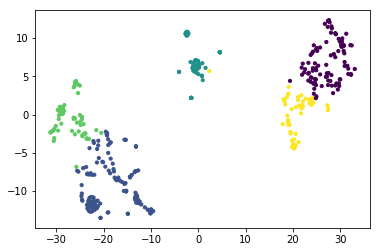

In [87]:
pos = TSNE(n_components=2).fit_transform(B[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=10,c=labels.labels_);

In [88]:
cmap=factor_cmap(field_name='c', palette=Spectral[K], factors=[str(i) for i in range(K)])

source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_df['title'],
            s=node_df['citCounts']/2,
            c=[str(i) for i in labels.labels_]
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s',color=cmap,source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)